In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Loading the behavioural/neural data

In [2]:
beh_data_dir = "data/COBAR_behaviour_incl_manual.pkl"
beh_data = pd.read_pickle(beh_data_dir)
neural_data_dir = beh_data_dir = "data/COBAR_neural.pkl"
neural_data = pd.read_pickle(neural_data_dir)

In [3]:
from scipy.signal import butter, filtfilt
def butter_lowpass_filter(data, cutoff, fs, order):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    # Get the filter coefficients 
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data, axis=0)
    return y

#filter angles in beh data
fs=100.0
order=2
cutoff=20
beh_df = beh_data.copy(deep=True)
angl=beh_data.filter(regex="angle")
filtered_angl = butter_lowpass_filter(angl, cutoff, fs, order)
beh_df.iloc[:,2:44]=filtered_angl
#filter neurons reading in neural data
neural_df = neural_data.copy(deep=True) #necessary to deep copy dataframe
fs=16.0
order=2
cutoff=2.5
neurons=neural_data.filter(regex="neuron")
filtered_neurons = butter_lowpass_filter(neurons, cutoff, fs, order)
neural_df.iloc[:,1:124]=filtered_neurons

beh_df=beh_data.copy(deep=True)
neural_df=neural_data.copy(deep=True)


 # WEEK 8 : Familiarisation with data, plotting

## Part 1 : Plotting the data

### 1. Plot time traces of individual neurons across multiple trials

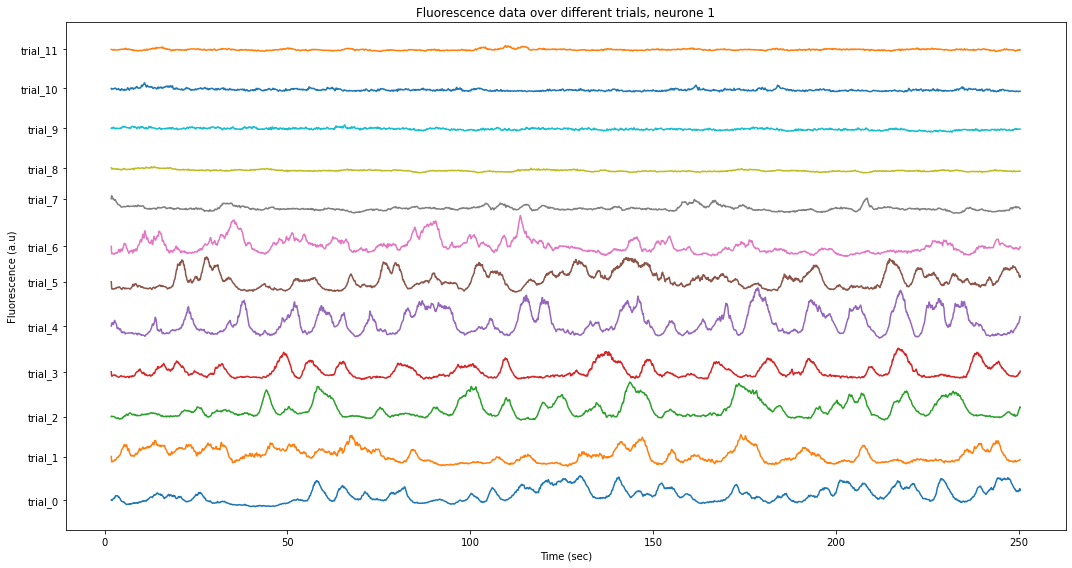

In [4]:
#Fluorescence data over different trials, neurone 1
neural_signals_neuron_1 = neural_df["neuron_1"]

# We construct a 3x3 matrix whose elements will be subplots depending on the column and row number they span
fig, ax1 = plt.subplots(figsize = (15,8))

ytick = []
for i in np.arange(12):   
    neural_signals_neuron_1_trial_i = neural_signals_neuron_1[neural_df.index.get_level_values("Trial")==i]
    #ax1.plot(neural_df["t"].iloc[:380], i*1500 + neural_signals_neuron_1_trial_i.iloc[:380], label = 'trial_' + str(i))
    ax1.plot(neural_df["t"].iloc[:4039], i*1500 + neural_signals_neuron_1_trial_i.iloc[:4039], label = 'trial_' + str(i))
    ytick.append(neural_signals_neuron_1_trial_i.iloc[0] + i*1500)
    
ax1.set_ylabel('Fluorescence (a.u)')
ax1.set_xlabel('Time (sec)')
ax1.set_title('Fluorescence data over different trials, neurone 1')

ax1.set_yticks(np.array(ytick))
neuron_names = ['trial_' + str(i) for i in range(12)]
ax1.set_yticklabels(neuron_names)


plt.tight_layout()
plt.show()
fig.savefig('report_images/w8_fluo_neurone1.png')

### 2. Plot time traces of individual angles/joints across multiple trials 

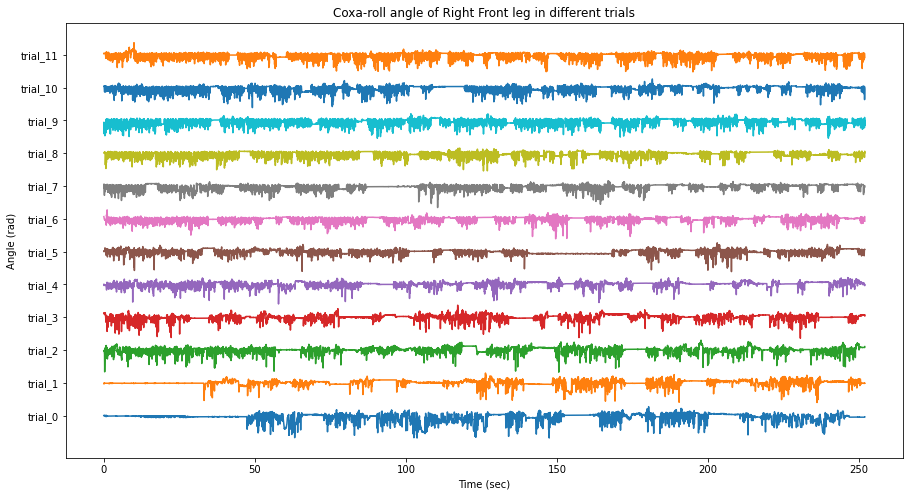

In [5]:
#Coxa-roll angle of Right Front leg in different trials
angle_RF_leg_roll = beh_df["angle_RF_leg_Coxa_roll"]
time = beh_df["t"]

fig, ax = plt.subplots(figsize = (15,8))
ytick = []

for i in range(12):
    y = angle_RF_leg_roll[angle_RF_leg_roll.index.get_level_values("Trial")==i]+3*i
    t=time[time.index.get_level_values("Trial")==i]
    plt.plot(t, y, alpha = 1) 
    ytick.append(angle_RF_leg_roll.iloc[0] + i*3)

ax.set_yticks(np.array(ytick))
trial_names = ['trial_' + str(i) for i in range(12)]
ax.set_yticklabels(trial_names)
ax.set_ylabel('Angle (rad)')
ax.set_xlabel('Time (sec)')
ax.set_title('Coxa-roll angle of Right Front leg in different trials')
plt.show()
fig.savefig('report_images/w8_Coxa-roll.png')

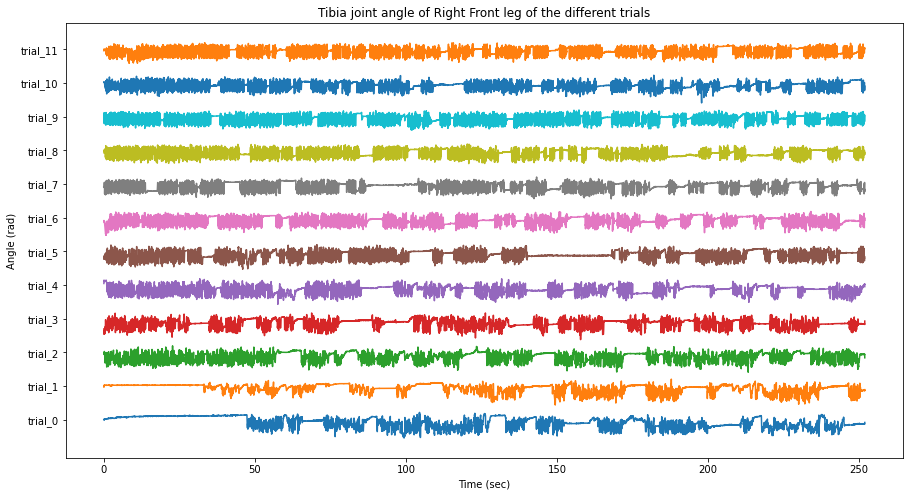

In [6]:
#Tibia joint angle of Right Front leg of the different trials
angle_RF_leg_Tibia = beh_df["angle_RF_leg_Tibia"]
time = beh_df["t"]

fig, ax = plt.subplots(figsize = (15,8))
ytick = []

for i in range(12):
    y = angle_RF_leg_Tibia[angle_RF_leg_Tibia.index.get_level_values("Trial")==i]+3*i
    t=time[time.index.get_level_values("Trial")==i]
    plt.plot(t, y, alpha = 1) 
    ytick.append(angle_RF_leg_Tibia.iloc[0] + i*3)

ax.set_yticks(np.array(ytick))
trial_names = ['trial_' + str(i) for i in range(12)]
ax.set_yticklabels(trial_names)
ax.set_ylabel('Angle (rad)')
ax.set_xlabel('Time (sec)')
ax.set_title('Tibia joint angle of Right Front leg of the different trials')
plt.show()
fig.savefig('report_images/w8_Tibia.png')

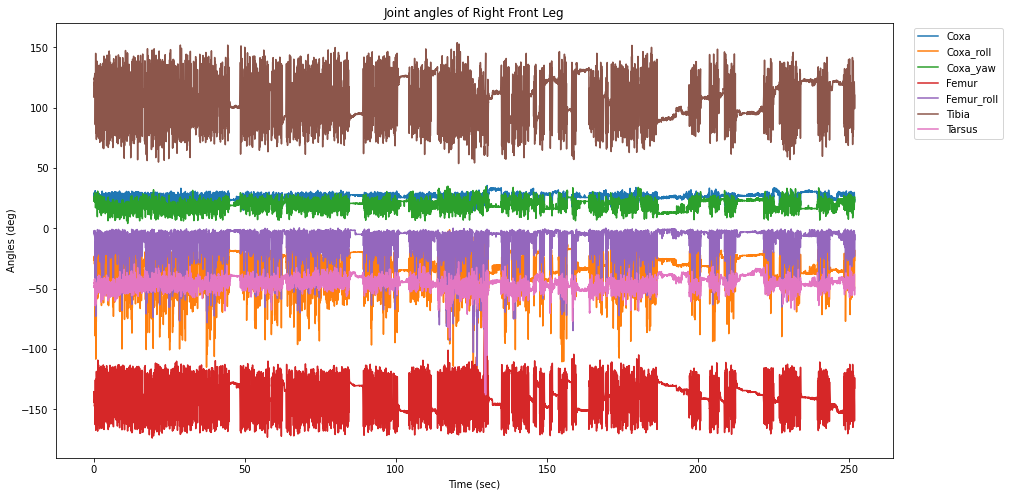

In [7]:
#plot of Joint angles of Right Front Leg
fig, ax2 = plt.subplots(figsize = (15,8))

beh_signals_trial_8 = beh_df[beh_df.index.get_level_values("Trial")==8]
joints = ['Coxa', 'Coxa_roll', 'Coxa_yaw', 'Femur', 'Femur_roll', 'Tibia', 'Tarsus']
leg_joints = ['angle_RF_leg_' + joint for joint in joints]

for i, joint in enumerate(leg_joints):   
    plt.plot(beh_signals_trial_8['t'], beh_signals_trial_8[joint]*180/np.pi, label = joints[i])

ax2.set_title('Joint angles of Right Front Leg')
ax2.set_ylabel('Angles (deg)')
ax2.set_xlabel('Time (sec)')
ax2.legend(bbox_to_anchor = (1.02,1))
fig.savefig('report_images/w8_all_joint.png')

## Part 2: Data pre-processing

### 1. ΔF/F

In [8]:
#Δ𝐹/𝐹 = (F − Fb)/𝐹b , where Fb is the baseline fluorescence.
rlt_Df_f=neural_df.copy(deep=True)

for j in np.arange(123): 
    baseline = neural_df['neuron_' + str(j)].rolling(window=3).mean()
    rlt_Df_f['neuron_' + str(j)] = (neural_df['neuron_' + str(j)]-abs(baseline.min()))/abs(baseline.min())

## Week 10 : Part 1.1 Identifying correlations of individual neurons

Compute the mean activity of a neuron during different behaviours. average the neuron’s activity separately during walking, resting, and so on.
Hint 1: You could visualise the results as colours of a matrix with individual neurons on
one axis and behaviours on the other axis.
Hint 2: Standardising the neuronal time-series to have mean zero and unit variance (i.e.,
z-scoring) may help with the visualisation.

In [39]:
#step1 : standardization
std_Df_f = rlt_Df_f.copy()

for j in np.arange(123): 
    baseline = rlt_Df_f['neuron_' + str(j)].mean()
    std_Df_f['neuron_' + str(j)] = (rlt_Df_f['neuron_' + str(j)]-rlt_Df_f['neuron_' + str(j)].mean())/(rlt_Df_f['neuron_' + str(j)].std())

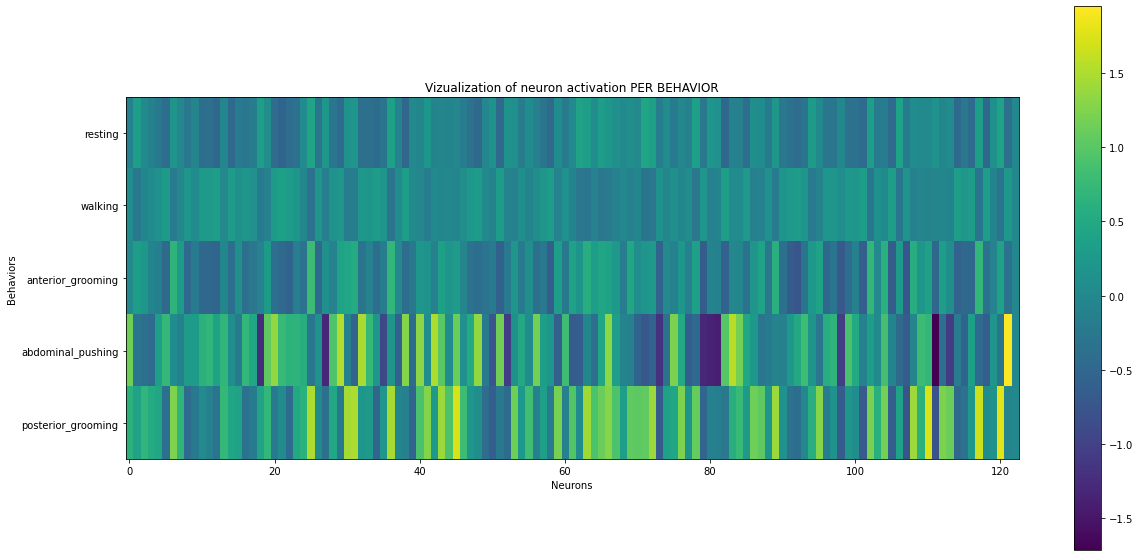

In [41]:
#step2 : vizualization of neuron activation PER BEHAVIOR

#get manual labelling of behaviors
std_Df_f['Manual'] = beh_df['Manual']
behaviors = ['resting', 'walking', 'anterior_grooming', 'abdominal_pushing', 'posterior_grooming']
ytick=[0,1,2,3,4]
val = np.zeros((5,123))

for i in range (len(behaviors)):
    b = behaviors[i]
    behavior_data = std_Df_f[std_Df_f['Manual']==b]
    behavior_data
    for j in range (122):
        val[i,j]=behavior_data['neuron_' + str(j)].mean()

fig, ax2 = plt.subplots(figsize = (20,10))
ax2.set_yticks(ytick)
ax2.set_yticklabels(behaviors)
ax2.set_title('Vizualization of neuron activation PER BEHAVIOR')
ax2.set_ylabel('Behaviors')
ax2.set_xlabel('Neurons')
plt.imshow(val, aspect=10)
plt.colorbar()
plt.show()
fig.savefig('report_images/neuron_act_per_behavior.png')

In [44]:
i=2
a=np.where(val[i]==val[i].max())
print(val[i,a])
val[i].max()

[[0.79244737]]


0.7924473694090428

### try to plot for some particular neurons where identification of behavior involved is easy to recognize
 1. abdominal pushing


In [14]:
neuron_beh = []
for i in range (len(behaviors)):
    for j in range (122):
        if abs(val[i,j]) > 1.0:
            neuron_beh.append(i)

1. investiguate in non-stable neurons
2. investiguate non-often firing neurons
3. investiguate
df.filter(regex=“neuron”)